# Segmentation on TCGA Brain tumor scans

##Importing data from Kaggle

In [1]:
!mkdir -p ~/.kaggle/

In [3]:
!mv kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 98% 697M/714M [00:21<00:00, 28.1MB/s]
100% 714M/714M [00:21<00:00, 34.5MB/s]


In [5]:
!unzip -q lgg-mri-segmentation.zip

##Setting up session (GPU) and importing libraries

In [7]:
import tensorflow as tf

In [8]:
tf.__version__

'2.7.0'

In [10]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec 25 10:42:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [83]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
#from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.utils import Sequence

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from keras.preprocessing import image

from sklearn.model_selection import train_test_split

from skimage.transform import resize

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import shutil
import PIL
import pathlib
import pandas as pd
import cv2
from imgaug import augmenters as iaa
import imgaug as ia

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools

import re

### Housekeeping

In [11]:
!mv kaggle_3m/README.md ./

In [12]:
!mv kaggle_3m/data.csv ./

In [13]:
patients_folders = os.listdir("kaggle_3m")

In [14]:
len(patients_folders)

110

In [15]:
!mkdir files

In [16]:
!mkdir files/masks && mkdir files/images

In [18]:
#The ground truth (mask) files have the word "mask" in the file name. 
#We use this to move all masks to files/masks folder and we put the rest in the #files/images
for folder in patients_folders:
  files = os.listdir(f'kaggle_3m/{folder}')
  
  for file in sorted(files):
    file_url = f'kaggle_3m/{folder}/{file}'
    
    if "mask" in file:
      shutil.move(file_url, "files/masks")
    else:
      shutil.move(file_url, "files/images")

In [19]:
images_paths = os.listdir("files/images")

In [20]:
len(images_paths)

3929

### Creating train and validation sets
We are using 80-20 train-val split

In [84]:
val_size = int(len(images_paths) * .20)

In [85]:
val_size

785

In [86]:
X_train = images_paths[val_size:]
X_val = images_paths[:val_size]

In [87]:
len(X_train), len(X_val)

(3144, 785)

##Data Generator

In [88]:
class DataGenerator(Sequence):
    def __init__(self, images_paths, batch_size=32, validation=False, predict=False, shuffle=True):
      self.batch_size = batch_size
      self.images_paths = images_paths
      self.shuffle = shuffle
      self.validation = validation
      self.predict = predict
      self.on_epoch_end()

    def __len__(self):
      return int(np.floor(len(self.images_paths) / self.batch_size))

    def __getitem__(self, index):
      from_range = index * self.batch_size
      to_range = (index + 1) * self.batch_size
      indexes = self.indexes[from_range:to_range]
      
      if self.predict:
        X = self.__load_predict__(indexes)
        return X
      
      else:
        X, y = self.__load__(indexes)
        return X, y

    def on_epoch_end(self):
      self.indexes = np.arange(len(self.images_paths))
      
      if self.shuffle == True:
          np.random.shuffle(self.indexes)
    
    def __load_image__(self, index):
      image_path = self.images_paths[index]
  
      image_loaded = image.load_img(f'files/images/{image_path}')
      image_loaded = image.img_to_array(image_loaded)
      image_loaded = resize(image_loaded, (input_shape), mode='constant', preserve_range=True)
      
      image_loaded = image_loaded / 255.0
      
      return image_loaded
    
    def __load_image_and_mask__(self, index):
      image_path = self.images_paths[index]
      mask_path = image_path[:-4] + "_mask.tif"
  
      image_loaded = image.load_img(f'files/images/{image_path}')
      image_loaded = image.img_to_array(image_loaded)
      image_loaded = resize(image_loaded, (input_shape), mode='constant', preserve_range=True)

      mask_loaded = image.img_to_array(image.load_img(f'files/masks/{mask_path}', color_mode="grayscale"))
      mask_loaded = resize(mask_loaded, (img_size, img_size, 1), mode='constant', preserve_range=True)
      
      image_loaded = image_loaded / 255.0
      mask_loaded = mask_loaded / 255.0
      
      return image_loaded, mask_loaded
    
    def __load_predict__(self, indexes):
      X = []
      
      for index in indexes:
        img = self.__load_image__(index)
        X.append(img)

      return np.array(X)
      
    def __load__(self, indexes):
      X = []
      y = []
      
      for index in indexes:
        img, mask = self.__load_image_and_mask__(index)
        X.append(img)
        y.append(mask)
      
      return np.array(X), np.array(y)

In [89]:
def downstream_block(layer, number_filters):
  layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
  cropped_feature_map = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
  layer = layers.MaxPool2D(2, strides=2, padding='same')(cropped_feature_map)
  
  return layer, cropped_feature_map

In [90]:
def upstream_block(layer, number_filters, cropped_feature_map):
  layer = layers.Conv2DTranspose(number_filters, (2, 2), strides=(2, 2), padding='same')(layer)
  layer = layers.concatenate([layer, cropped_feature_map])
  layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
  layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
  
  return layer

In [91]:
def u_net():
  input = layers.Input(input_shape)
  layer = input
  
  cropped_feature_maps = []
  
  for index in range(steps + 1):
    current_number_filters = number_filters * 2 ** index
    layer, cropped_feature_map = downstream_block(layer, current_number_filters)
    cropped_feature_maps.append(cropped_feature_map)
  
  layer = cropped_feature_maps.pop()
  
  for index in range(steps - 1, -1, -1):
    current_number_filters = number_filters * 2 ** index
    layer = upstream_block(layer, current_number_filters, cropped_feature_maps[index])
  
  output = layers.Conv2D(number_classes, 1, activation='sigmoid')(layer)
  model = Model(input, output)
  
  return model

In [92]:
input_shape = (256, 256, 3)
img_size = 256
number_filters = 16 
steps = 4
number_classes = 1

In [93]:
model = None
model = u_net()

In [130]:
batch_size = 32

learning_rate = 3e-4
epochs = 40

In [131]:
def polynomial_decay(epoch):
	power = 1.0
 
	alpha = learning_rate * (1 - (epoch / float(epochs))) ** power
	return alpha

In [146]:
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [147]:
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy'])

In [148]:
train_steps = int(len(X_train) / batch_size)
val_steps = int(len(X_val) / batch_size)

In [149]:
train_steps, val_steps

(98, 24)

In [150]:
train_generator = DataGenerator(X_train, batch_size)
val_generator = DataGenerator(X_val, batch_size, validation=True)

In [151]:
trained_model = model.fit_generator(train_generator,
                                    epochs=epochs,
                                    steps_per_epoch=train_steps,
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=val_steps,
                                    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/40
98/98 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9908
Epoch 00001: val_accuracy improved from -inf to 0.99240, saving model to weights-improvement-01-0.99.hdf5
98/98 [==============================] - 55s 554ms/step - loss: 0.0383 - accuracy: 0.9908 - val_loss: 0.0239 - val_accuracy: 0.9924
Epoch 2/40
98/98 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9930
Epoch 00002: val_accuracy improved from 0.99240 to 0.99423, saving model to weights-improvement-02-0.99.hdf5
98/98 [==============================] - 55s 562ms/step - loss: 0.0236 - accuracy: 0.9930 - val_loss: 0.0183 - val_accuracy: 0.9942
Epoch 3/40
98/98 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9945
Epoch 00003: val_accuracy improved from 0.99423 to 0.99516, saving model to weights-improvement-03-1.00.hdf5
98/98 [==============================] - 55s 560ms/step - loss: 0.0165 - accuracy: 0.9945 - val_loss: 0.0172 - val_accuracy: 0.995

In [152]:
model.load_weights("/content/weights-improvement-36-1.00.hdf5")

In [153]:
def print_image_and_masks(X, index):
  image_path = X[index]
  mask_path = image_path[:-4] + "_mask.tif"

  image_loaded = image.load_img(f'files/images/{image_path}')
  image_loaded = image.img_to_array(image_loaded)
  image_loaded = resize(image_loaded, (input_shape), mode='constant', preserve_range=True)
  
  mask_loaded = image.img_to_array(image.load_img(f'files/masks/{mask_path}', color_mode="grayscale"))
  mask_loaded = resize(mask_loaded, (img_size, img_size, 1), mode='constant', preserve_range=True)

  image_loaded = image_loaded / 255.0
  mask_loaded = mask_loaded / 255.0
  
  image_array = np.expand_dims(image_loaded, axis=0)
  
  predictions = model.predict(image_array)
  
  mask_predicted = predictions[0]
  
  has_mask = mask_loaded.max() > 0

  fig, ax = plt.subplots(1, 3, figsize=(10, 10))
  ax[0].imshow(image_loaded)

  if has_mask:
      ax[0].contour(mask_loaded.reshape(256, 256), colors='k', levels=[0.5])
  ax[0].set_title('Original image')

  ax[1].imshow(mask_loaded.reshape(256, 256))
  ax[1].set_title('True Mask')

  ax[2].imshow(mask_predicted.reshape(256, 256), vmin=0, vmax=1)

  if has_mask:
      ax[2].contour(mask_loaded.reshape(256, 256), colors='k', levels=[0.5])
  ax[2].set_title('Predicted Mask')

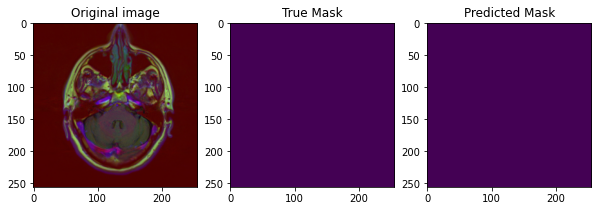

In [154]:
print_image_and_masks(X_train, 0)

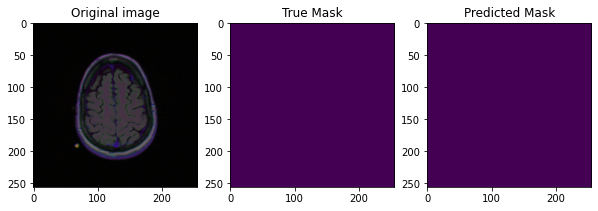

In [160]:
print_image_and_masks(X_train, 14)

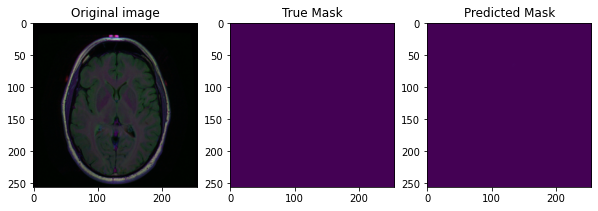

In [158]:
print_image_and_masks(X_val, 10)